In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path

import numpy as np
import torch

from PycalcAct.dataset import Dataset
from PycalcAct.model import (
    MixedFCTemporalModel,
)
from PycalcAct.trainer import Trainer

_ = torch.manual_seed(1234)


In [3]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",  # Optional
    position_to_displacement=True,
    remove_mean=False,
    replace_nan_by_min=True,
    # Convert the x, y position to a single displacement value (sqrt((x(t+1)-x(t))^2 + (y(t+1)-y(t))^2)
)


def create_model():
    return MixedFCTemporalModel(
        n_classes=dataset.n_classes,
        temporal_length=dataset.length_serie,
        input_size=dataset.features,
        n_rnn_layers=3,
        dropout=0.5,
    )


model = create_model()

n_epochs = 500
trainer = Trainer(
    dataset, model, device="cuda"
)  # You can pass your own optimizer, criterion, learning rate, weight decay and learning rate scheduler.


╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.39 │                     42.32 │
│             5             │                      1.36 │                     43.56 │
│             6             │                      1.35 │                     44.38 │
│             10            │                      1.35 │                     45.92 │
│             14            │                      1.34 │                     45.95 │
│             43            │                      1.33 │                     46.22 │
│             44            │                      1.33 │                     46.25 │
│             47            │                      1.33 │                     46.82 │
│             48            │                      1.3

AttributeError: 'Dataset' object has no attribute 'mapping'

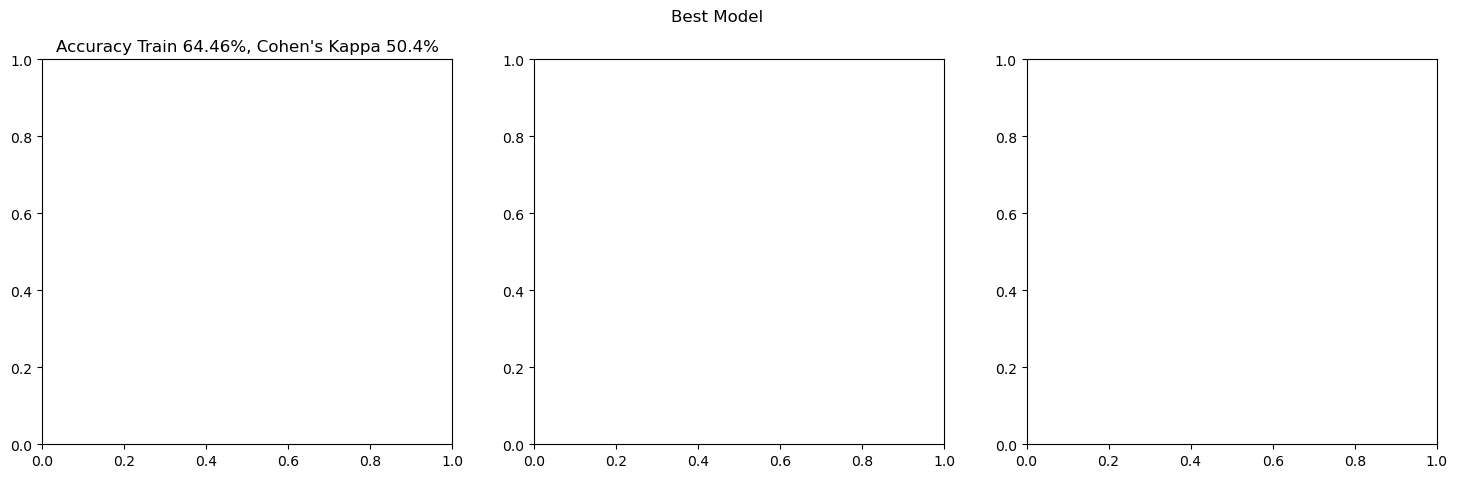

In [4]:
for i in range(41, 50):
    torch.manual_seed(i + 50)
    np.random.seed(i + 50)
    model = create_model()
    trainer = Trainer(dataset, model, device="cuda")
    trainer.train(n_epochs=n_epochs, verbose=True)
    trainer.save(f"uncertainty/checkpoints/seed_{i}.pth")

trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model

In [10]:
# trainer.load_best()
x_val, y_val = dataset.val_batch(True, True)

preds = []
losses = []
for i in range(50):
    trainer.load(f"uncertainty/checkpoints/seed_{i}.pth")
    trainer.load_last()
    pred = trainer.predict(x_val)
    preds.append(pred)
    losses.append(trainer.get_loss(x_val, y_val, average=False))
    trainer.load_best()
    pred = trainer.predict(x_val)
    preds.append(pred)
    losses.append(trainer.get_loss(x_val, y_val, average=False))

preds = torch.stack(preds)
losses = torch.stack(losses)

In [11]:
mean = preds.mean(dim=0)
std = preds.var(dim=0)
mean_loss = losses.mean(dim=0)

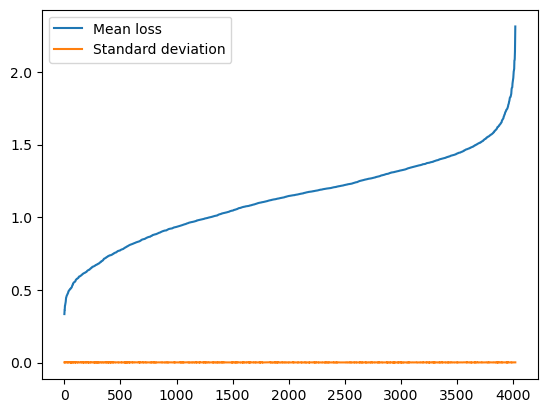

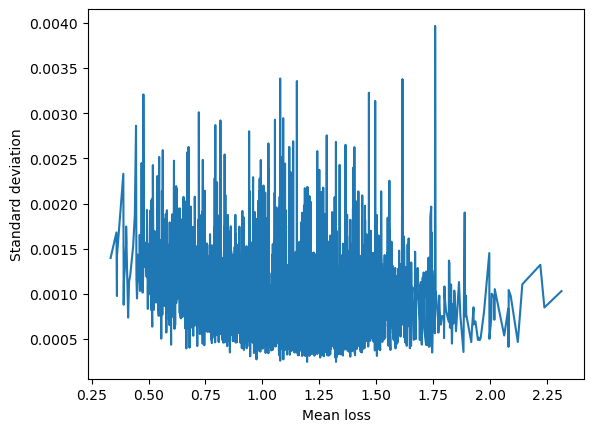

In [12]:
import matplotlib.pyplot as plt

argsort = mean_loss.argsort()
mean_loss = mean_loss[argsort]
std = std[argsort]
uncertainty = std.max(1).values
x_val = x_val[argsort]
y_val = y_val[argsort]
mean = mean[argsort]
plt.plot(mean_loss.cpu().numpy(), label="Mean loss")
plt.plot(uncertainty.cpu().numpy(), label="Standard deviation")
plt.legend()
plt.show()
plt.plot(
    mean_loss.cpu().numpy(),
    uncertainty.cpu().numpy(),
)
plt.xlabel("Mean loss")
plt.ylabel("Standard deviation")

plt.show()

# uncertainty = losses.std(0)[argsort]


In [18]:
thresholds = torch.linspace(uncertainty.min() * 1.01, uncertainty.max(), 50).cuda()
kappas = []
npoints = []
for t in thresholds:
    # quantile = torch.quantile(uncertainty, t)  # 95% quantile of the uncertainty
    quantile = t
    n_uncertain = (uncertainty > quantile).sum()
    x_filtered = x_val[uncertainty < quantile]
    y_filtered = y_val[uncertainty < quantile]
    print(
        f"Number of uncertain samples with a quantile of {t:.2f} ({quantile:.2f}): {n_uncertain} (remaining {len(x_filtered)})"
    )

    trainer.metrics.reset()
    trainer.metrics(mean[uncertainty < quantile], y_filtered)

    scores = trainer.metrics.compute()
    kappas.append(scores["CohenKappa"].item())
    npoints.append(n_uncertain.item() / len(x_val))

    print(f"On mean: Accuracy {scores['Accuracy']:.2%} - Kappa {scores['CohenKappa']:.2f}")
    print(50 * "-")


Number of uncertain samples with a quantile of 0.00 (0.00): 4020 (remaining 2)
On mean: Accuracy 0.00% - Kappa -0.33
--------------------------------------------------
Number of uncertain samples with a quantile of 0.00 (0.00): 3998 (remaining 24)
On mean: Accuracy 45.83% - Kappa 0.17
--------------------------------------------------
Number of uncertain samples with a quantile of 0.00 (0.00): 3887 (remaining 135)
On mean: Accuracy 47.41% - Kappa 0.25
--------------------------------------------------
Number of uncertain samples with a quantile of 0.00 (0.00): 3638 (remaining 384)
On mean: Accuracy 50.52% - Kappa 0.30
--------------------------------------------------
Number of uncertain samples with a quantile of 0.00 (0.00): 3264 (remaining 758)
On mean: Accuracy 51.19% - Kappa 0.32
--------------------------------------------------
Number of uncertain samples with a quantile of 0.00 (0.00): 2867 (remaining 1155)
On mean: Accuracy 53.16% - Kappa 0.35
---------------------------------

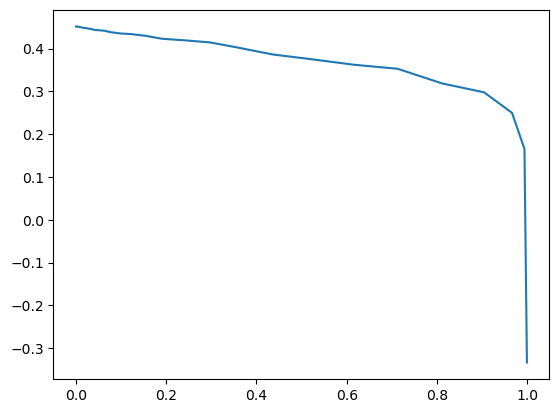

In [19]:
plt.plot(npoints, kappas)

In [ ]:
from 